## Importing Dependencies

In [5]:
from IPython import display
display.clear_output()

import ultralytics
ultralytics.checks()

from ultralytics import YOLO

import os
import shutil
import yaml
import random
import cv2
import matplotlib.pyplot as plt 
from PIL import Image

Ultralytics 8.3.95  Python-3.13.2 torch-2.6.0+cu126 CUDA:0 (NVIDIA GeForce GTX 1650 SUPER, 4096MiB)
Setup complete  (16 CPUs, 15.9 GB RAM, 406.6/465.2 GB disk)


## Defining Useful Functions

### Aggregating Datasets

In [1]:
def combine_datasets(max_images: int = 100000):
    """
    Combines all the datasets in the "datasets" folders into a single dataset in a "combined_dataset" folder.

    Parameters:
    max_images (int): The maximum number of images to take from each set.
    """

    # Classes to convert other labels to
    standard_classes = {
        "fire": 0,
        "smoke": 1,
        "default": 2
    }

    # Delete folder and rebuild
    shutil.rmtree("combined_dataset", ignore_errors=True)
    for split_folder in ("train", "val", "test"):
        for folder in ("images", "labels"):
            os.makedirs(f"combined_dataset/{split_folder}/{folder}", exist_ok=True)

    # Create YAML file
    yaml_data = {
        "names": list(standard_classes.keys()),
        "nc": len(standard_classes),
        "train": "train/images",
        "val": "val/images",
        "test": "test/images"
    }
    with open("combined_dataset/data.yaml", "w") as file:
        yaml.dump(yaml_data, file)

    # Copy and remap data from each dataset
    for dataset_folder in os.listdir("datasets"):
        # Parse the yaml file to get the classes for this folder
        yaml_data = None
        with open(f"datasets/{dataset_folder}/data.yaml") as stream:
            yaml_data = yaml.safe_load(stream)
            classes = {i: name.lower() for i, name in enumerate(yaml_data["names"])}
            splits = {split: yaml_data[split] for split in ("train", "val", "test")}

            for split, split_folder in splits.items():
                if not split_folder: continue
                labels_folder = os.path.join(os.path.dirname(split_folder), "labels")

                # Copy at most max_images
                image_files = os.listdir(f"datasets/{dataset_folder}/{split_folder}")
                random.shuffle(image_files)
                image_files = image_files[:max_images]
                
                for image_file in image_files:
                    try:
                        name, _ = os.path.splitext(image_file)
                        
                        # Copy image
                        shutil.copy(f"datasets/{dataset_folder}/{split_folder}/{image_file}", f"combined_dataset/{split}/images/{image_file}")

                        # Remap labels
                        with open(f"datasets/{dataset_folder}/{labels_folder}/{name}.txt") as file:
                            with open(f"combined_dataset/{split}/labels/{name}.txt", "w") as new_file:
                                for line in file:
                                    class_id, coords = line.split(" ", 1)
                                    class_id = int(class_id)
                                    class_name = classes[class_id]
                                    new_class_id = standard_classes[class_name]
                                    new_file.write(f"{new_class_id} {coords}")
                    except Exception as e:
                        print(e)

### Predicting n Random Images

In [2]:
def predict_n_images(folder: str, n: int):
    """
    Run prediction on n images from the given folder, showing the true labels on the left and the predictions on the right.

    Parameters:
    folder (str): The path to the folder containing the images to predict.
    n (int): The number of images to take from the folder.
    """

    # Randomize and select n images
    image_files = os.listdir(f"{folder}/images")
    random.shuffle(image_files)
    image_files = image_files[:n]

    model = YOLO("best.pt")
    
    # Get the class ids and names from the yaml file
    with open(f"{folder}/../data.yaml") as stream:
        yaml_data = yaml.safe_load(stream)
        classes = {i: name.lower() for i, name in enumerate(yaml_data["names"])}

        # Run prediction on every image
        for image_file in image_files:
            fig, ax = plt.subplots(1, 2, figsize=(12, 12))

            file_name, ext = os.path.splitext(image_file)
            image_path = f"{folder}/images/{image_file}"
            results = model.predict(image_path, verbose=False)

            # Get true labels and bounding boxes
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            im_height, im_width, _ = image.shape
            with open(f"{folder}/labels/{file_name}.txt") as file:
                for line in file:
                    class_id, coords = line.split(" ", 1)
                    class_id = int(class_id)
                    x_center, y_center, width, height = (float(coord) for coord in coords.split(" "))
                    x1, x2 = int((x_center - width/2) * im_width), int((x_center + width/2) * im_width)
                    y1, y2 = int((y_center - height/2) * im_height), int((y_center + height/2) * im_height)
                    class_name = classes[class_id]
                    cv2.rectangle(image, (x1+10, y1+10), (x2-10, y2-10), (255, 0, 0), 2)
                    cv2.putText(image, class_name, (x1+20, y1+40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            ax[0].imshow(image)
            ax[0].axis('off')

            # Get predicted labels and bounding boxes
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            for boxes in results[0].boxes:
                for i, coords in enumerate(boxes.xyxy):
                    class_id = boxes.cls[i]
                    x1, y1, x2, y2 = (int(coord) for coord in coords)
                    class_name = "smoke" if class_id else "fire"
                    cv2.rectangle(image, (x1+10, y1+10), (x2-10, y2-10), (255, 0, 0), 2)
                    cv2.putText(image, class_name, (x1+20, y1+40), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
            ax[1].imshow(image)
            ax[1].axis('off')

            # Plot results
            plt.subplots_adjust(wspace=0, hspace=.02)
            plt.show()

### Plotting Model Accuracy

In [3]:
def run_tests(max_images: int = 1000000):
    """
    Computes the model accuracy for all of the datasets in the datasets folder.

    Parameters:
    max_images (int): The maximum number of images to take from each set.
    """

    # Load model
    model = YOLO(f"best.pt")

    # Extract classes and datasets from yaml file
    yaml_data = None
    with open(f"data.yaml") as stream:
        yaml_data = yaml.safe_load(stream)
    model_classes = {i: name.lower() for i, name in enumerate(yaml_data["names"])}

    dataset_names: list[str] = []
    dataset_accuracies: list[str] = []
    dataset_sizes: list[int] = []

    # Test model on every dataset in the "datasets" folder
    for dataset_folder in os.listdir("datasets"):
        # Parse the yaml file to get the classes and splits for this folder
        yaml_data = None
        with open(f"datasets/{dataset_folder}/data.yaml") as stream:
            yaml_data = yaml.safe_load(stream)
            classes = {i: name.lower() for i, name in enumerate(yaml_data["names"])}
            class_names = set(classes.values())
            splits = {split: yaml_data[split] for split in ("train", "val", "test")}
            
            # Test every split of the dataset
            for split, split_folder in splits.items():
                if not split_folder: continue
                labels_folder = os.path.join(os.path.dirname(split_folder), "labels")

                # Test at most max_images
                image_files = os.listdir(f"datasets/{dataset_folder}/{split_folder}")
                random.shuffle(image_files)
                image_files = image_files[:max_images]
                
                errors = 0
                for image_file in image_files:
                    try:
                        name, _ = os.path.splitext(image_file)

                        actual = set()      # Actual detections
                        predicted = set()   # Predicted detections
                        
                        # Get the actual detections
                        with open(f"datasets/{dataset_folder}/{labels_folder}/{name}.txt") as file:
                            for line in file:
                                class_id = int(line.split(" ")[0])
                                class_name = classes[class_id]
                                actual.add(class_name)
                        
                        # Get the predicted detections
                        results = model.predict(f"datasets/{dataset_folder}/{split_folder}/{image_file}", verbose=False)
                        for class_id in results[0].boxes.cls:
                            class_name = model_classes[int(class_id)]
                            predicted.add(class_name)

                        # An error can be either:
                        #   A lack of detection when there should be one
                        #   A detection when there should not be one
                        for class_name in predicted | actual:
                            # False negative
                            if class_name in actual and class_name not in predicted:
                                errors += 1
                                break
                            # False positive
                            if class_name in predicted and (class_name not in actual and class_name in class_names):
                                errors += 1
                                break
                    except Exception as e:
                        print(e)

                dataset_names.append(f"{dataset_folder}/{split}")
                dataset_accuracies.append(100 - 100 * errors/len(image_files))
                dataset_sizes.append(len(image_files))
        
    # Plot results
    num_bars = len(dataset_names)
    cmap = plt.cm.get_cmap('plasma', num_bars)
    colors = [cmap(i) for i in range(num_bars)]

    fig, ax = plt.subplots()
    fig.set_size_inches(12, 9)
    ax.bar(dataset_names, dataset_accuracies, color=colors)

    xlocs=[i for i in range(num_bars)]
    for i, v in enumerate(dataset_accuracies):
        plt.text(xlocs[i], v + 1, f"{round(v, 1)}%", ha="center")
    
    plt.title("Model Accuracy on Different Datasets")
    plt.xlabel("Dataset")
    plt.ylabel("Accuracy (%)")
    plt.show()

### Video Inferencing

In [4]:
def predict_video(src, out=False):
    """
    Runs the model on the given video source, outputting its predictions in real time.

    Parameters:
    src (str or float): The video source. Can be a string for the path to a video file, or 0 to use the web cam.
    out (str): The file path to write the annotated video to.
    """
    
    model = YOLO("best.pt")
    cap = cv2.VideoCapture(src)

    # Set up VideoWriter if out
    if out:
        width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*'XVID')
        out = cv2.VideoWriter(out, fourcc, fps, (width, height))
    
    while cap.isOpened():
        ret, frame = cap.read()
    
        if not ret:
            break

        # Create annotated frame
        results = model.predict(frame, verbose=False)
        annotated_frame = results[0].plot()
        pil_image = Image.fromarray(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))

        # Write frame if out
        if out:
            out.write(annotated_frame)


        # Display frame
        display.clear_output(True)
        display.display(pil_image)
    
        if cv2.waitKey(1) == ord('q'):
            break
    
    if out:
        out.release()
    
    cap.release()
    cv2.destroyAllWindows()

## Testing our Model

### Predicting n Random Images

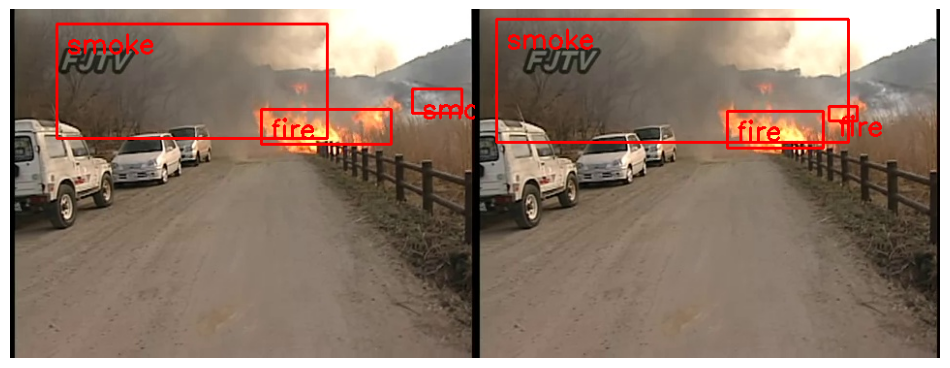

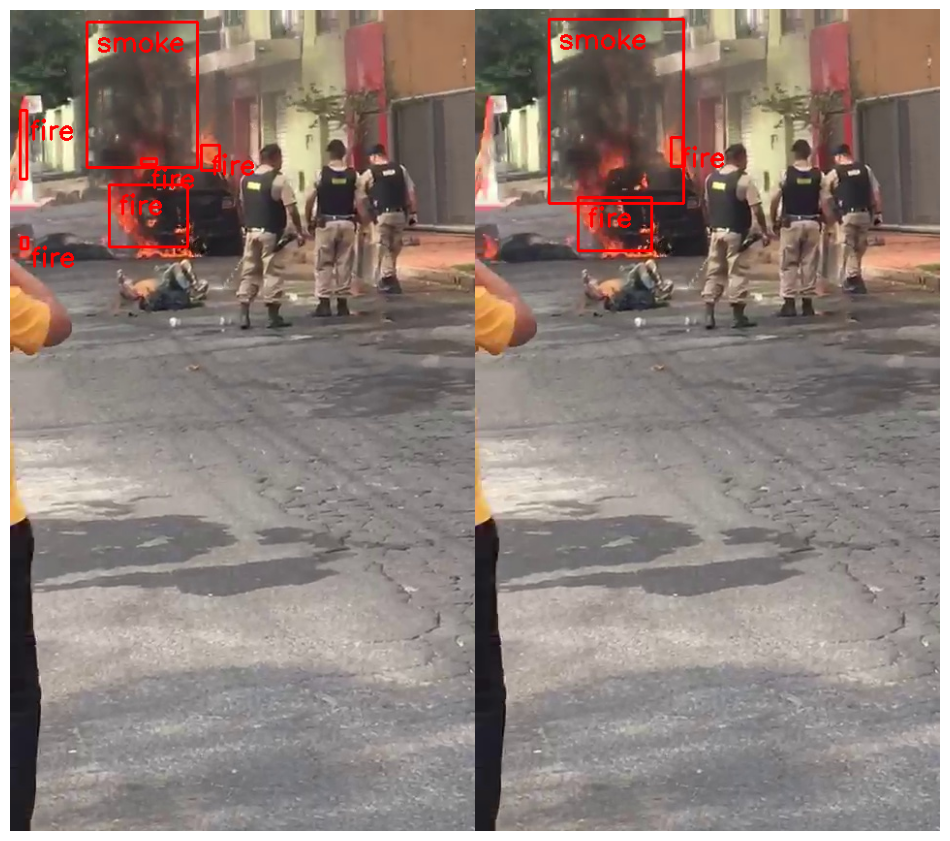

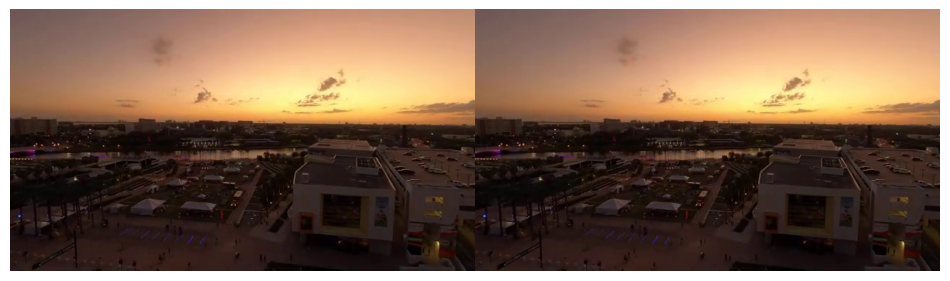

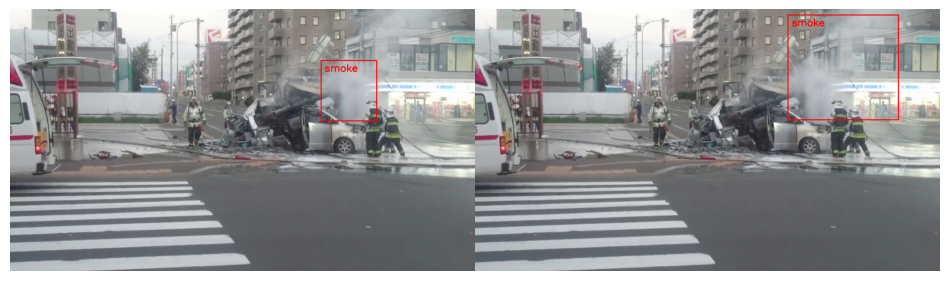

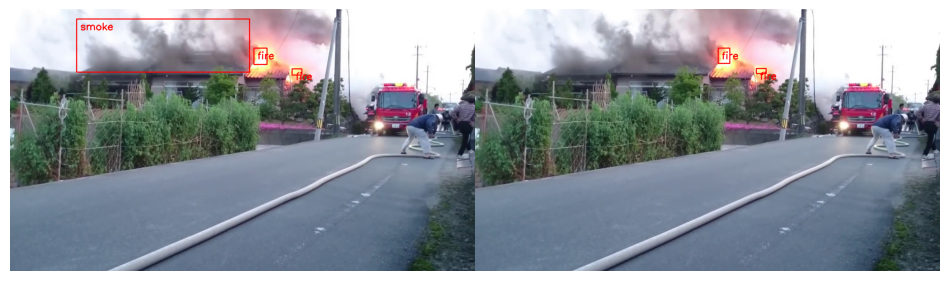

In [184]:
# Predict 5 images from the test folder in the combined dataset
predict_n_images("combined_dataset/test", 5)

### Plotting Model Accuracy

C:\Users\kevin\AppData\Local\Temp\ipykernel_25640\3760045900.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma', num_bars)


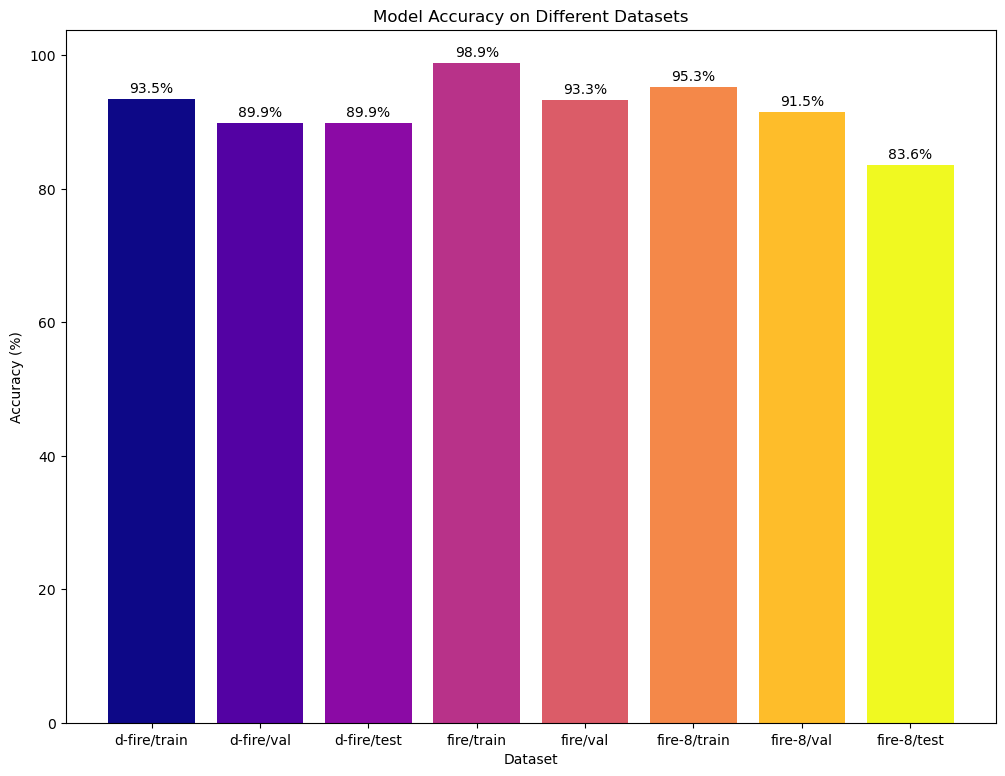

In [ ]:
# Plot model accuracy on all datasets, 1000 random images from each set
run_tests(1000)

### Video Inferencing

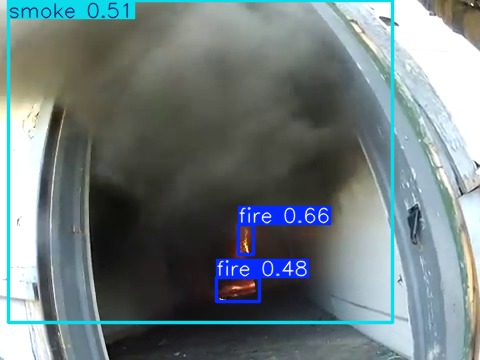

In [10]:
# Run model on a video
predict_video("video_detections/input/firefighter.mp4")